# Re-analysis from Pelka et al. (2019)

In [1]:
from plotnine import *
import numpy as np
import pandas as pd

## Expression in Ki67+ cancer cells
From the Loupe file provided for epithelial, we first selected cancer cells based on more than 2 counts for both LY6E and TGFBI. Among these cells, the ones with more than 2 counts for MKI67 were labelled as proliferation "High" while the others were classified as "Low".

In [2]:
labels = pd.read_csv("../../data/pelka-reanalysis/Labels-Ki67.csv", index_col=0)
labels.head()

,Prolif
Barcode,
AAACCTGGTTGTCGCG-1,Epi
AAACCTGTCCTTGGTC-1,Epi
AAACGGGCAGAGTGTG-1,Malignant
AAAGATGCAAGGTTTC-1,Malignant
AAAGATGGTGCCTGCA-1,Epi


In [3]:
expr = pd.read_csv("../../data/pelka-reanalysis/Expression-Ki67.csv", index_col=0, sep =";")
print(expr.shape)
expr.head()

(168672, 6)


,GLUL,SLC16A1,SLC7A5,SLC3A2,CYCS,CPT1A
Barcode,,,,,,
AAACCTGCATGCTAGT-1,0,0,3,0,5,0
AAACCTGGTAGCCTAT-1,0,1,0,0,1,0
AAACCTGGTTGTCGCG-1,4,1,3,3,13,0
AAACCTGTCATGTGGT-1,0,0,0,1,6,0
AAACCTGTCCTTGGTC-1,7,2,2,0,31,2


In [4]:
expr = expr.join(labels, how="inner")

In [5]:
# Display violin plots of metabolic marker intensity per cell
# Split by aggressiveness (low = right violin, high = left violin)

# Rename values for clarity
expr["Proliferation"] = expr.Prolif.replace({"Epi": "Low", "Malignant": "High"})

# Reorder by pathway
path_order = ["CYCS", "CPT1A", "SLC16A1", "SLC7A5", "SLC3A2", "GLUL"]

# Convert to long format
df_long = pd.melt(expr.loc[:,path_order+["Proliferation"]], id_vars=["Proliferation"], value_vars=path_order)

df_long["variable"] = pd.Categorical(df_long["variable"], 
    categories=path_order,
    ordered=True)

df_long["variable"] = df_long["variable"].replace({
    "CYCS": "CYCS\n(CytC)",
    "SLC16A1": "SLC16A1\n(MCT1)",
    "SLC7A5": "SLC7A5\n(CD98)",
    "SLC3A2": "SLC3A2\n(CD98)",
    "GLUL": "GLUL\n(GS)",
})

/tmp/ipykernel_55142/4289163624.py:17: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.


/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 6 x 4.5 in image.
/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: ../../figures/fig6/expression_ki67_cancer_pelka.pdf


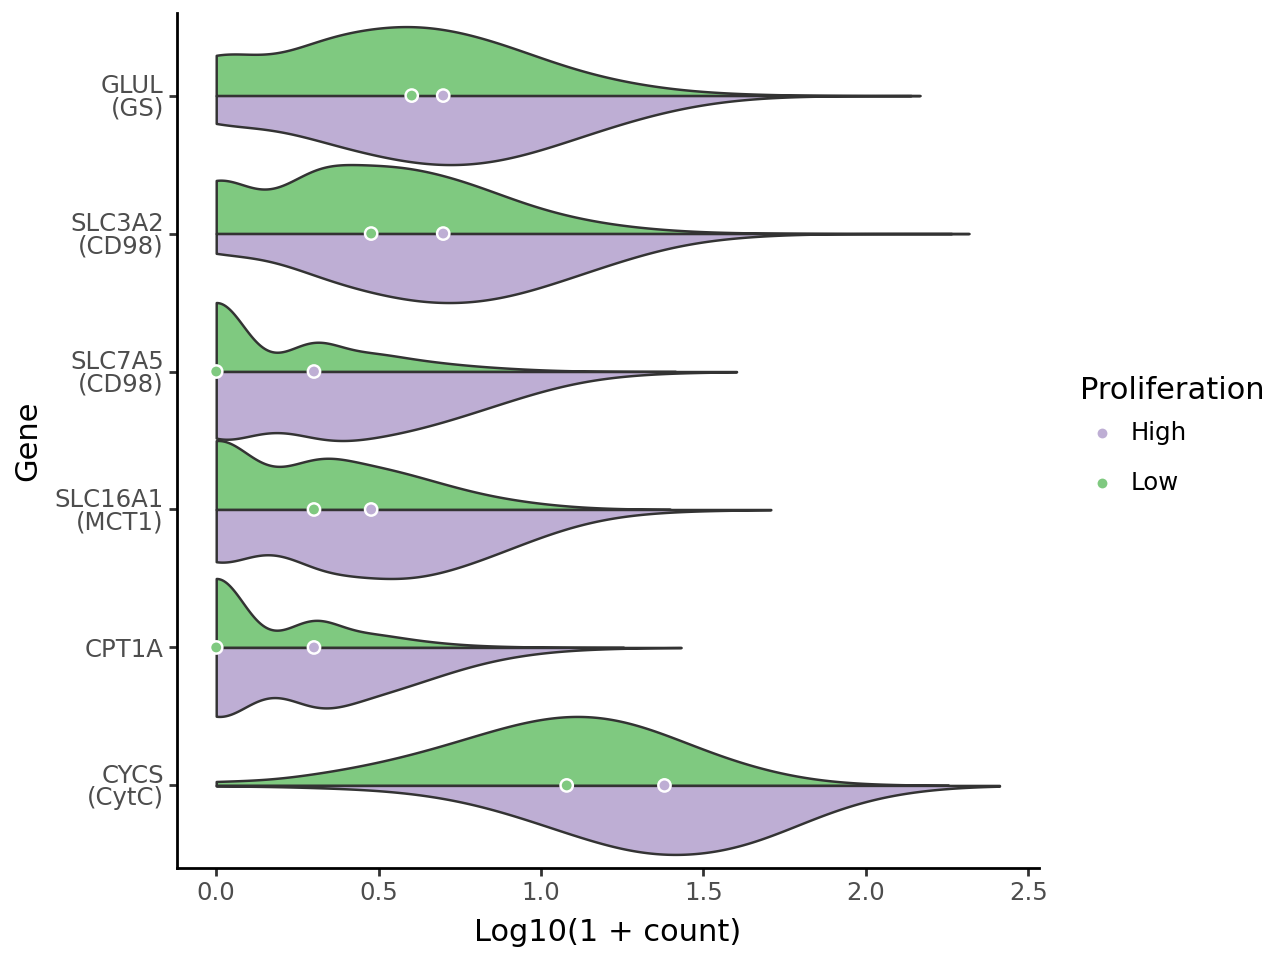

In [6]:
df_long["logvalue"] = np.log10(1 + df_long["value"])

gp = ggplot(df_long, aes(x="variable", y="logvalue")) +\
    geom_violin(data = df_long.loc[df_long.Proliferation == "Low",:], 
                fill = "#7fc980", 
                style="right", 
                scale="width", 
                width = 1,
                adjust = 3) +\
    geom_violin(data = df_long.loc[df_long.Proliferation == "High",:], 
                fill = "#beaed4", 
                style="left", 
                scale="width", 
                width = 1,
                adjust = 3) +\
    stat_summary(data = df_long, 
                 mapping = aes(fill = "Proliferation"),
                 fun_y=np.median, geom='point', color='white', 
                 size=2) +\
    scale_fill_manual(values = ["#beaed4", "#7fc980"]) +\
    theme_classic() +\
    coord_flip() +\
    ylab("Log10(1 + count)") +\
    xlab("Gene") +\
    guides(fill=guide_legend(title="Proliferation"))

ggsave(gp, "../../figures/fig6/expression_ki67_cancer_pelka.pdf", width = 6, height = 4.5)
gp

Note: CA9 and ARG1 had median expression of 0 in both conditions.

## Healthy and malignant Ki67+ epithelial cells

In [7]:
enrich_healthy = pd.read_csv("../../data/pelka-reanalysis/EnrichmentProlifHealthy.csv", index_col=0)
assert np.all(np.isclose(enrich_healthy["Malignant P-Value"], enrich_healthy["Healthy P-Value"]))
enrich_healthy = enrich_healthy.loc[enrich_healthy["Malignant P-Value"] < 0.05]
print(enrich_healthy.shape)
enrich_healthy.head()

(383, 7)


,FeatureName,Malignant Average,Malignant Log2 Fold Change,Malignant P-Value,Healthy Average,Healthy Log2 Fold Change,Healthy P-Value
FeatureID,,,,,,,
ENSG00000168748,CA7,0.004402,-8.683770,3.275457e-150,1.835195,8.683770,3.275457e-150
ENSG00000044012,GUCA2B,0.025938,-7.065188,2.066761e-23,3.482780,7.065188,2.066761e-23
ENSG00000167434,CA4,0.039502,-5.106959,4.213039e-66,1.363538,5.106959,4.213039e-66
ENSG00000197888,UGT2B17,0.335711,-5.084487,1.158406e-150,11.398083,5.084487,1.158406e-150
ENSG00000269404,SPIB,0.059313,-4.992681,6.164232e-105,1.890719,4.992681,6.164232e-105


In [8]:
enrich_tumor = pd.read_csv("../../data/pelka-reanalysis/EnrichmentProlifCancer.csv", index_col=0)
# Drop LY6E and TGFBI, enriched by design
enrich_tumor.drop(["ENSG00000160932", "ENSG00000120708"], inplace=True)
enrich_tumor = enrich_tumor.loc[enrich_tumor["Malignant P-Value"] < 0.05]
print(enrich_tumor.shape)
enrich_tumor.head()

(476, 7)


,FeatureName,Malignant Average,Malignant Log2 Fold Change,Malignant P-Value,Healthy Average,Healthy Log2 Fold Change,Healthy P-Value
FeatureID,,,,,,,
ENSG00000229314,ORM1,1.450169,7.370762,6.149262e-35,0.008182,-7.370762,6.149262e-35
ENSG00000167244,IGF2,2.274723,6.641699,8.438969e-39,0.022209,-6.641699,8.438969e-39
ENSG00000172016,REG3A,34.510515,6.183227,2.049746e-26,0.474579,-6.183227,2.049746e-26
ENSG00000100604,CHGA,1.044792,5.804671,1.984985e-02,0.018118,-5.804671,1.984985e-02
ENSG00000185269,NOTUM,1.035095,5.703756,7.523507e-25,0.019287,-5.703756,7.523507e-25


In [9]:
# Merge tables
enrich_tumor = pd.concat([enrich_tumor, enrich_healthy])

In [10]:
# See https://decoupler.readthedocs.io/en/latest/notebooks/bulk/rna.html
import decoupler as dc
data = pd.DataFrame(enrich_tumor["Malignant Log2 Fold Change"]).set_index(enrich_tumor["FeatureName"]).T

collectri = dc.op.collectri(organism='human')
tf_acts, tf_padj = dc.mt.ulm(data=data, net=collectri)
msk = (tf_padj.T < 0.05).iloc[:, 0]
tf_acts = tf_acts.loc[:, msk]

tf_acts

/home/loan/miniforge3/envs/liana/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


,AP1,ATF1,CEBPD,CTNNB1,CUX1,EGR1,FOS,GLI1,GTF3A,HIF1A,...,JUN,LEF1,NEUROD1,NFKB,SP1,SSRP1,STAT1,STAT3,TCF4,TCF7L2
Malignant Log2 Fold Change,5.06113,3.104655,3.473717,4.609352,2.912415,3.207477,2.941769,3.054263,3.288581,3.21506,...,3.168175,3.40793,2.991366,3.323389,4.17241,4.512965,3.221749,4.142913,3.582622,3.683113


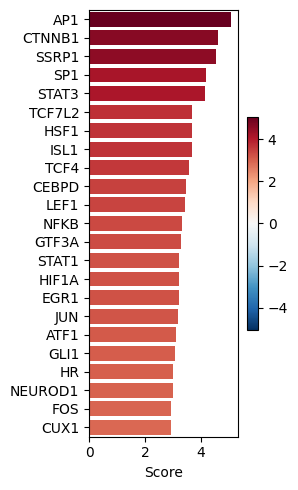

In [11]:
from matplotlib import pyplot as plt
dc.pl.barplot(
    data=tf_acts,
    name='Malignant Log2 Fold Change',
    top=25,
    figsize=(3, 5)
)
plt.show()

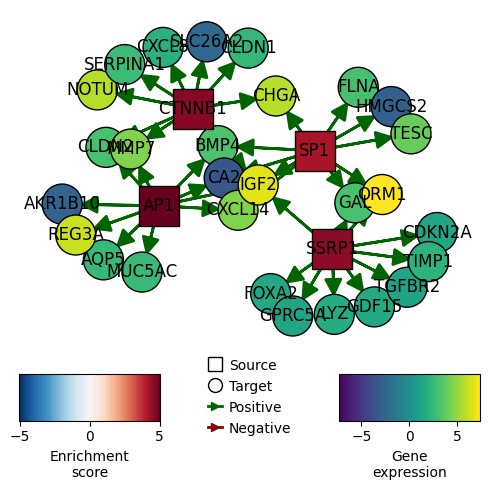

In [12]:
dc.pl.network(
    net=collectri,
    data=data,
    score=tf_acts,
    sources=['AP1', 'CTNNB1', 'SSRP1', 'SP1'],
    targets=10,
    figsize=(5, 5),
    vcenter=True,
    by_abs=True,
    size_node=10
)
plt.show()

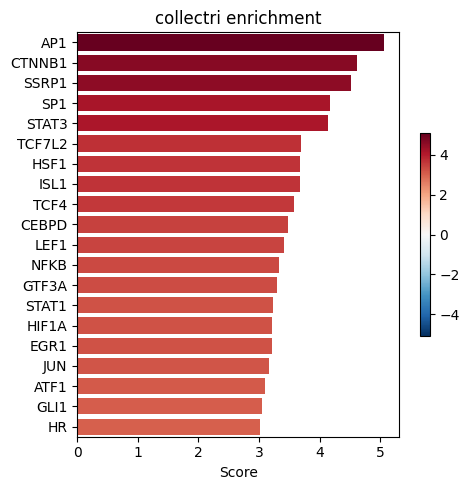

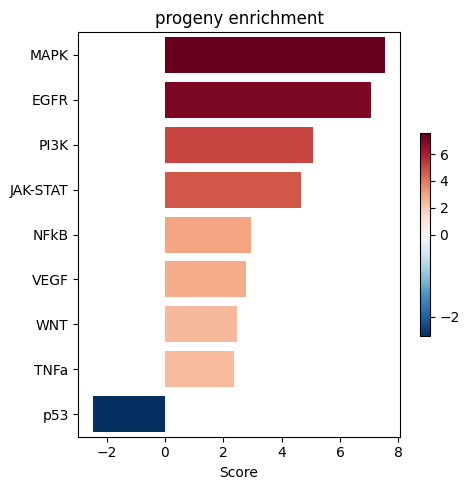

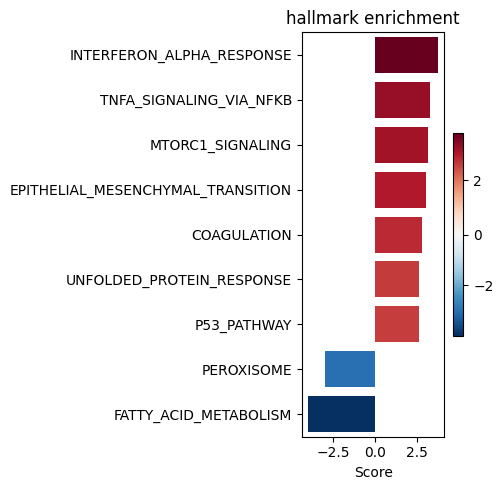

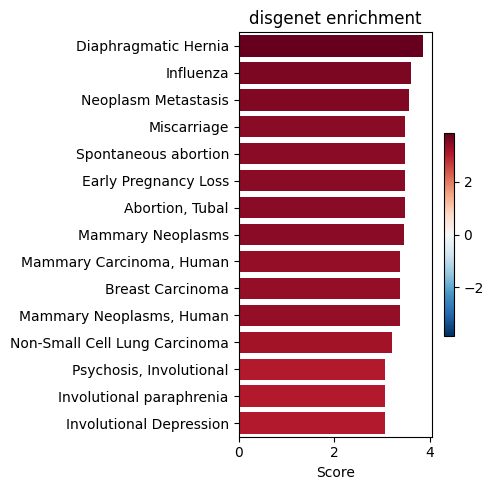

No significant results for kegg.


In [13]:
# Prepare resources
disgenet_df = dc.op.resource('DisGeNet')
disgenet_df.rename(columns={"disease": "source", "genesymbol": "target"}, inplace=True)
disgenet_df = disgenet_df.loc[:,["target", "source"]].drop_duplicates()
kegg_df = dc.op.resource("KEGG-PC")
kegg_df.rename(columns={"pathway": "source", "genesymbol": "target"}, inplace=True)
kegg_df = kegg_df.loc[:,["target", "source"]].drop_duplicates()
assert len(set(kegg_df.target).intersection(set(data.columns))) > 0

resources = {
    "collectri": dc.op.collectri(organism='human'),
    "progeny": dc.op.progeny(organism='human'),
    "hallmark": dc.op.hallmark(organism='human'),
    "disgenet": disgenet_df,
    "kegg": kegg_df,
}

for res_name, res in resources.items():
    acts, padj = dc.mt.ulm(data=data, net=res)
    
    # Filter by sign padj
    msk = (padj.T < 0.05).iloc[:, 0]
    acts = acts.loc[:, msk]

    if acts.shape[1] == 0:
        print(f"No significant results for {res_name}.")
        continue
    
    dc.pl.barplot(
        data=acts,
        name='Malignant Log2 Fold Change',
        top=20,
        figsize=(5, 5)
    )
    plt.title(f"{res_name} enrichment")
    plt.show()

    